
1) Use qiskit-nature and pyscf driver to input molecular coordinates and obtain the second-quantized-hamiltonian
2) Map it using standard mappers such as JordanWigner and obtain the Qubit Hamiltonian.
3) Get the initial Hartree-Fock State.
4) Use chemistry inspired ansatz (UCCSD) and set initial parameters to be zeros. 
5) Use SLSQP Classical optimizer to perform VQE.

Use qiskit-aer simulator as you have used before, the output should be the Potential Energy Surface (PES) scan for the H2 molecule. Please update us daily on what's the status of the work, and if you are struck somewhere so that we can help you out. 



In [1]:
import qiskit_nature
import pyscf

print("Qiskit Nature version:", qiskit_nature.__version__)
print("PySCF version:", pyscf.__version__)


Qiskit Nature version: 0.7.2
PySCF version: 2.8.0


In [ ]:
#CODE FOR THE GSE CALC OF A H2 AT A FIXED BOND LENGTH(using ucssd)

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.algorithms.initial_points import HFInitialPoint
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_aer.primitives import Estimator as AerEstimator  
import numpy as np

driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
problem = driver.run()


mapper = JordanWignerMapper()

# Defining UCCSD ansatz and inital hf state
num_spatial_orbitals = problem.num_spatial_orbitals
num_particles = problem.num_particles
hf_initial_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
ansatz = UCCSD(num_spatial_orbitals, num_particles, mapper, initial_state=hf_initial_state)

# can use HF as the initial point for more accurate res
# initial_point = HFInitialPoint()
# initial_point.ansatz = ansatz
# initial_point.problem = problem
# vqe.initial_point = initial_point.to_numpy_array()
# vqe = VQE(Estimator(), ansatz, optimizer)


optimizer = SLSQP()
vqe = VQE(AerEstimator(), ansatz, optimizer)

#intital paras=0
vqe.initial_point = np.zeros(ansatz.num_parameters)


solver = GroundStateEigensolver(mapper, vqe)
result = solver.solve(problem)


print(f"Total ground state energy = {result.total_energies[0]:.4f}")


Total ground state energy = -0.7001


Bond length: 0.20 Å -> Energy: 0.163481 Hartree
Bond length: 0.29 Å -> Energy: -0.569870 Hartree
Bond length: 0.39 Å -> Energy: -0.882950 Hartree
Bond length: 0.48 Å -> Energy: -1.028634 Hartree
Bond length: 0.58 Å -> Energy: -1.094024 Hartree
Bond length: 0.67 Å -> Energy: -1.116641 Hartree
Bond length: 0.77 Å -> Energy: -1.115416 Hartree
Bond length: 0.86 Å -> Energy: -1.100742 Hartree
Bond length: 0.96 Å -> Energy: -1.078428 Hartree
Bond length: 1.05 Å -> Energy: -1.051755 Hartree
Bond length: 1.15 Å -> Energy: -1.022699 Hartree
Bond length: 1.24 Å -> Energy: -0.992577 Hartree
Bond length: 1.34 Å -> Energy: -0.962337 Hartree
Bond length: 1.43 Å -> Energy: -0.932669 Hartree
Bond length: 1.53 Å -> Energy: -0.904065 Hartree
Bond length: 1.62 Å -> Energy: -0.876856 Hartree
Bond length: 1.72 Å -> Energy: -0.851252 Hartree
Bond length: 1.81 Å -> Energy: -0.827372 Hartree
Bond length: 1.91 Å -> Energy: -0.805266 Hartree
Bond length: 2.00 Å -> Energy: -0.784931 Hartree


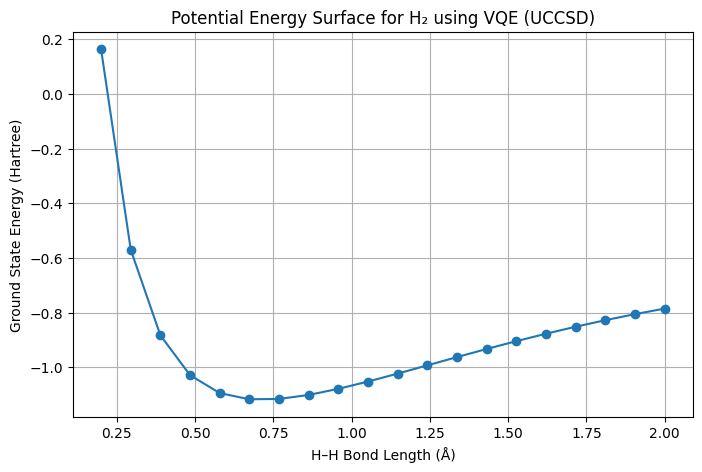

In [ ]:
#CODE FOR GSE AT VARYING BOND LENGTHS AND PLOTTING THE PES
import numpy as np
import matplotlib.pyplot as plt

from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_aer.primitives import Estimator as AerEstimator  


bond_lengths = np.linspace(0.2, 2.0, 20)  # Angstroms
energies = []

for r in bond_lengths:
    molecule = MoleculeInfo(["H", "H"], [(0.0, 0.0, 0.0), (0.0, 0.0, r)], charge=0, multiplicity=1)
    driver = PySCFDriver.from_molecule(molecule, basis="sto3g")
    problem = driver.run()


    
    mapper = JordanWignerMapper()

    
    ansatz = UCCSD(
        problem.num_spatial_orbitals,
        problem.num_particles,
        mapper,
        initial_state=HartreeFock(
            problem.num_spatial_orbitals,
            problem.num_particles,
            mapper
        )
    )

    
    optimizer = SLSQP(maxiter=1000)
    estimator = AerEstimator(run_options={"shots": 1024, "seed": 42})
    vqe = VQE(estimator, ansatz, optimizer)
    vqe.initial_point = np.zeros(ansatz.num_parameters)

    
    solver = GroundStateEigensolver(mapper, vqe)
    result = solver.solve(problem)

    print(f"Bond length: {r:.2f} Å -> Energy: {result.total_energies[0]:.6f} Hartree")
    energies.append(result.total_energies[0])

# 
plt.figure(figsize=(8, 5))
plt.plot(bond_lengths, energies, marker='o')
plt.title("Potential Energy Surface for H₂ using VQE (UCCSD)")
plt.xlabel("H–H Bond Length (Å)")
plt.ylabel("Ground State Energy (Hartree)")
plt.grid(True)
plt.show()

